# Data Analyst Interview Project with SQL

These are results of an interview project looking at fake interpreter call data with data saved on an AWS database and using PostgreSQL.

In [275]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
import plotly.plotly as py
import plotly.graph_objs as go
import numpy as np

In [137]:
conn = psycopg2.connect()# Removed to protect company information.
cur=conn.cursor()

## First Deliverable

### 1. Create a list of 10 companies who use the most Spanish minutes. Include Company Name, number of Spanish minutes and the total number of minutes (all languages) in the list ordered by number of Spanish minutes

In [36]:
cur.execute("\
SELECT company_name, \
SUM(CASE WHEN language='Spanish' THEN duration ELSE 0 END) \
AS Spanish_Minutes,SUM(duration) AS Total_Minutes \
FROM call_data GROUP BY company_name ORDER BY Spanish_Minutes DESC LIMIT 10")
rows=cur.fetchall()
df1_1=pd.DataFrame(rows)
df1_1.columns=[desc[0] for desc in cur.description]

In [38]:
df1_1.head(10)

,company_name,spanish_minutes,total_minutes
0,Very Big Corp. of America,536013,2027147
1,Cyberdyne Systems,530378,2000845
2,Pied Piper,528173,2030362
3,Wonka Industries,522599,2039398
4,Stark Industries,521750,2029113
5,Nakatomi Trading Corp.,521681,1974943
6,Umbrella Corporation,521293,2026409
7,Oscorp,517225,2005373
8,Massive Dynamic,515407,1991872
9,Acme Corp,515033,2007459


### 2. What is the average duration for Spanish, Somali and Estonian

In [44]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT language, AVG(duration) AS Average_Duration \
FROM call_data \
WHERE language='Spanish' OR language='Somali' OR language='Estonian' \
GROUP BY language")
rows=cur.fetchall()
df1_2=pd.DataFrame(rows)
df1_2.columns=[desc[0] for desc in cur.description]

In [45]:
df1_2.head()

,language,average_duration
0,Estonian,101.3877805486284289
1,Somali,100.1839030722630896
2,Spanish,100.6170947466439047


The averages are displayed in the above table.

### 3.  What is the average interpreter hold time for Spanish. What about the average interpreter hold time for all languages for the company named Hooli

In [48]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT \
  AVG(CASE WHEN language='Spanish' THEN interpreter_hold_time END) AS Spanish_Interpreter_Hold_Average, \
  AVG(CASE WHEN company_name='Hooli' THEN interpreter_hold_time END) AS Hooli_Interpreter_Hold_Average \
FROM call_data;")
rows=cur.fetchall()
df1_3=pd.DataFrame(rows)
df1_3.columns=[desc[0] for desc in cur.description]

In [49]:
df1_3.head()

,spanish_interpreter_hold_average,hooli_interpreter_hold_average
0,45.5686091927265203,45.4307986320659827


The average hold time for a Spanish interpreter is 45.6 and for Hooli (all languages) is 45.4.

### 4.  When did the first Korean call occur? What about the first Korean call for the company Wayne Enterprises?

In [51]:
cur.close()
cur=conn.cursor()
cur.execute("\
(SELECT company_name, call_start FROM call_data WHERE language='Korean' \
ORDER BY call_start LIMIT 1) \
UNION ALL \
(SELECT company_name, call_start FROM call_data WHERE language='Korean' \
AND company_name='Wayne Enterprises' ORDER BY call_start LIMIT 1)")
rows=cur.fetchall()
df1_4=pd.DataFrame(rows)
df1_4.columns=[desc[0] for desc in cur.description]
print(df1_4.head())

        company_name                call_start
0              Hooli 2018-01-01 01:11:00+00:00
1  Wayne Enterprises 2018-01-01 04:36:00+00:00


The first Korean call occured on 1/1/2018 at 1:11.  The first Korean call for Wayne Enterprises was on 1/1/2018 at 4:36.

### 5.  Create a report that lists call start formatted in separate columns for date and time formatted in 12-hour format for time, language, company name, patient name, department, and duration. The report should be ordered by company and then by date and time so that the report can easily be divided and sent to the various clients.

In [54]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT \
TO_CHAR(call_start,'YYYY-MM-DD') AS Call_Date, \
TO_CHAR(call_start,'hh:mi:ssAM') AS Call_Time, \
language, company_name, patient_name, department, duration \
FROM call_data ORDER BY company_name, call_start")
rows=cur.fetchall()
df1_5=pd.DataFrame(rows)
df1_5.columns=[desc[0] for desc in cur.description]
print(df1_5.head())

    call_date   call_time language company_name        patient_name  \
0  2018-01-01  12:02:00AM  Spanish    Acme Corp     Winnifred Madle   
1  2018-01-01  12:04:00AM  Italian    Acme Corp       Naoma Bromige   
2  2018-01-01  12:09:00AM  Spanish    Acme Corp     Gearalt Saunier   
3  2018-01-01  12:10:00AM   French    Acme Corp  Trev Van den Broek   
4  2018-01-01  12:10:00AM  Spanish    Acme Corp        Denny Amberg   

        department  duration  
0      Engineering        41  
1            Legal       199  
2       Accounting        96  
3  Human Resources       159  
4        Marketing        20  


In [61]:
df1_5.to_csv('IanSnyderFirstDeliverablePart5report.csv')

## Second Deliverable

### Create a list of all companies and their services in two different formats 
#### i) Company Name | Service Name 1, Service Name 2  


In [113]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT companies.name, string_agg(services.type, ',') AS service_name \
FROM companies \
INNER JOIN services \
ON companies.id=services.company_id \
GROUP BY companies.name")
rows=cur.fetchall()
df2_1i=pd.DataFrame(rows)
df2_1i.columns=[desc[0] for desc in cur.description]
pd.set_option('display.max_colwidth', -1)
print(df2_1i)

                      name                                                                                                                                                                        service_name
0  Hooli                    TelephoneInterpretingService,TelephoneInterpretingService,TelephoneInterpretingService                                                                                            
1  Wayne Enterprises        ScheduledTelephoneInterpretingService,VideoInterpretingService,TelephoneInterpretingService                                                                                       
2  Spacely Space Sprockets  DocumentTranslationService,ScheduledTelephoneInterpretingService,OnsiteInterpretingService,VideoInterpretingService,TelephoneInterpretingService                                  
3  Stark Industries         TelephoneInterpretingService                                                                                                                    

#### ii)Company Name | Service Name 1 
#### Company Name | Service Name 2

In [75]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT DISTINCT companies.name, services.type AS service_name \
from companies INNER JOIN services \
ON companies.id = services.company_id")
rows=cur.fetchall()
df2_1ii=pd.DataFrame(rows)
df2_1ii.columns=[desc[0] for desc in cur.description]
print(df2_1ii)

                       name                           service_name
0                 Acme Corp           TelephoneInterpretingService
1          Stark Industries           TelephoneInterpretingService
2   Spacely Space Sprockets             DocumentTranslationService
3                     Hooli           TelephoneInterpretingService
4   Spacely Space Sprockets               VideoInterpretingService
5   Spacely Space Sprockets           TelephoneInterpretingService
6         Wayne Enterprises  ScheduledTelephoneInterpretingService
7         Wayne Enterprises               VideoInterpretingService
8                 Acme Corp  ScheduledTelephoneInterpretingService
9         Wayne Enterprises           TelephoneInterpretingService
10  Spacely Space Sprockets              OnsiteInterpretingService
11  Spacely Space Sprockets  ScheduledTelephoneInterpretingService
12                Acme Corp               VideoInterpretingService


### 2. Create a list of all companies that do not have any active services.

In [80]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT companies.name \
from companies FULL OUTER JOIN services \
ON companies.id = services.company_id \
WHERE services.type IS NULL")
rows=cur.fetchall()
df2_2=pd.DataFrame(rows)
df2_2.columns=[desc[0] for desc in cur.description]
print(df2_2)

                        name
0          Cyberdyne Systems
1     Nakatomi Trading Corp.
2           Wonka Industries
3       Umbrella Corporation
4  Very Big Corp. of America
5                 Pied Piper
6                    Initech
7            Massive Dynamic
8                     Oscorp
9                 Gekko & Co


### 3. Create a list of all companies that have Telephone Interpreting Service but do not have Scheduled Telephone Interpreting Service

In [99]:
cur.close()
cur=conn.cursor() 
#cte1 just contains telephone interpreter services, ct2e just contains scheduled telephone interpreter services
cur.execute("\
with \
cte1 as( \
SELECT DISTINCT company_id, type \
FROM services \
WHERE ('ScheduledTelephoneInterpretingService' LIKE '%' || type || '%') AND ('TelephoneInterpretingService' LIKE '%' || type || '%') \
), \
cte2 as(\
SELECT DISTINCT company_id, type \
FROM services \
WHERE ('ScheduledTelephoneInterpretingService' LIKE '%' || type || '%') AND NOT ('TelephoneInterpretingService' LIKE '%' || type || '%') \
), \
cte3 as( \
SELECT cte1.company_id, cte1.type, cte2.type FROM cte1 \
FULL OUTER JOIN cte2 ON cte1.company_id=cte2.company_id \
WHERE cte2.type ISNULL) \
SELECT companies.name \
from companies INNER JOIN cte3 \
ON companies.id = cte3.company_id ")
rows=cur.fetchall()
df2_3=pd.DataFrame(rows)
df2_3.columns=[desc[0] for desc in cur.description]
print(df2_3)

               name
0  Stark Industries
1             Hooli


Stark Industries and Hooli have Telephone Interpreting Service but not have Scheduled Telephone Interpreting Service

## Third Deliverable

### 1. Create a script in either Python or R (python preferred) that does the following.  Connects to the database, grabs the data in call_data and...
#### i) ... creates output of the following, summing duration and averaging hold time for each company by day in the data set:
#### Company Name | Duration | Hold Time | Date

In [240]:
conn = psycopg2.connect() #removed information
cur=conn.cursor()
cur.execute("\
SELECT company_name, SUM(duration) AS duration, \
ROUND(AVG(interpreter_hold_time), 2) AS hold_time, TO_CHAR(call_start,'YYYY-MM-DD') AS date \
FROM call_data \
GROUP BY company_name, date")
rows=cur.fetchall()
df3_1=pd.DataFrame(rows)
df3_1.columns=[desc[0] for desc in cur.description]
print(df3_1)

          company_name  duration hold_time        date
0     Acme Corp         21595     47.53     2018-01-01
1     Acme Corp         16128     44.30     2018-01-02
2     Acme Corp         22091     43.00     2018-01-03
3     Acme Corp         24776     43.89     2018-01-04
4     Acme Corp         22497     43.57     2018-01-05
5     Acme Corp         18715     47.24     2018-01-06
6     Acme Corp         21467     44.79     2018-01-07
7     Acme Corp         22519     44.64     2018-01-08
8     Acme Corp         21040     45.75     2018-01-09
9     Acme Corp         20794     42.91     2018-01-10
10    Acme Corp         23383     47.09     2018-01-11
11    Acme Corp         22830     46.98     2018-01-12
12    Acme Corp         23108     45.23     2018-01-13
13    Acme Corp         19462     46.33     2018-01-14
14    Acme Corp         22264     44.89     2018-01-15
15    Acme Corp         19751     41.78     2018-01-16
16    Acme Corp         21934     49.70     2018-01-17
17    Acme

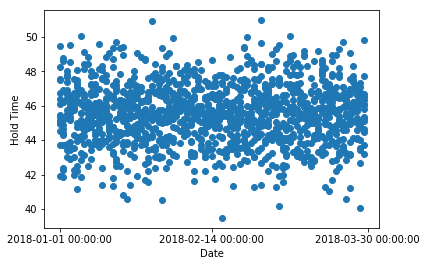

In [274]:
fig, ax = plt.subplots()
plt.plot_date(df3_1['date'], df3_1['hold_time'], xdate=True)
a=pd.to_datetime((df3_1.date.min()))
c=pd.to_datetime((df3_1.date.max()))
b=a + (c - a)/2
ax.set_xticks([0, 43, 87])
ax.set_xticklabels([str(a), str(b), str(c)])
ax.set_ylabel("Hold Time")
ax.set_xlabel("Date")
plt.show()

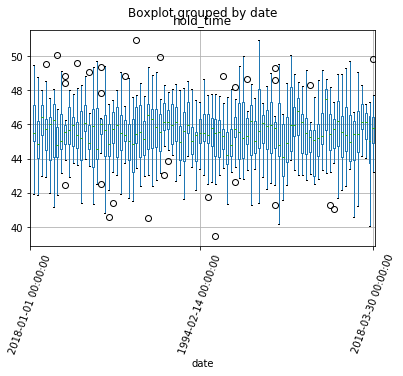

In [232]:
df3_1['date']=pd.to_datetime(df3_1.date)
#print(df3_1['date'])
df3_1['date']=pd.to_numeric(df3_1.date)
df3_1['hold_time']=pd.to_numeric(df3_1['hold_time'])
ax = df3_1.boxplot(by='date', column='hold_time', rot=70)
ax.set_xticks([0, 43, 87])
ax.set_xticklabels([pd.to_datetime(df3_1.date.min()), pd.to_datetime(df3_1.date.max()/2), pd.to_datetime(df3_1.date.max())])
plt.show()

It appears that the average hold time has held roughly steady over the course of time.  There could be a slight periodic increase and decrease of average hold time depending on the date, but the uncertainty is large.    

#### ii) ... creates output of the following, summing duration and averaging hold time for each language by day in the data set:
#### Language | Duration | Hold Time | Date

In [130]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT language, SUM(duration) AS duration, \
ROUND(AVG(interpreter_hold_time), 2) AS hold_time, \
TO_CHAR(call_start,'YYYY-MM-DD') AS date \
FROM call_data \
GROUP BY language, date")
rows=cur.fetchall()
df3_2=pd.DataFrame(rows)
df3_2.columns=[desc[0] for desc in cur.description]
print(df3_2)

       language  duration hold_time        date
0     Afrikaans  2074      41.22     2018-01-01
1     Afrikaans  2057      51.90     2018-01-02
2     Afrikaans  2114      49.00     2018-01-03
3     Afrikaans  2660      50.56     2018-01-04
4     Afrikaans  1936      44.70     2018-01-05
5     Afrikaans  2510      48.38     2018-01-06
6     Afrikaans  2256      49.95     2018-01-07
7     Afrikaans  1925      50.37     2018-01-08
8     Afrikaans  3641      48.20     2018-01-09
9     Afrikaans  2957      53.39     2018-01-10
10    Afrikaans  3360      47.43     2018-01-11
11    Afrikaans  2881      52.44     2018-01-12
12    Afrikaans  2643      48.75     2018-01-13
13    Afrikaans  1692      49.00     2018-01-14
14    Afrikaans  3255      42.04     2018-01-15
15    Afrikaans  1827      44.70     2018-01-16
16    Afrikaans  2428      49.50     2018-01-17
17    Afrikaans  2647      45.96     2018-01-18
18    Afrikaans  2591      46.59     2018-01-19
19    Afrikaans  2148      49.27     201

Looking at correlation between duration and hold time to see if there is a correlation between how long a call lasts and how long the hold time is.  First break it down to languages since the hold time for one language can be high while another is low.

In [290]:
languageSet=np.array(list(set(df3_2['language'])))
print(languageSet)

['Dhivehi' 'Indonesian' 'Somali' 'Montenegrin' 'Tajik' 'Moldovan'
 'West Frisian' 'Dari' 'Malayalam' 'Marathi' 'Danish' 'Chinese' 'Amharic'
 'Papiamento' 'Assamese' 'Spanish' 'Belarusian' 'Albanian' 'Catalan'
 'Haitian Creole' 'Kyrgyz' 'Guaraní' 'Gagauz' 'Tok Pisin' 'Punjabi'
 'Polish' 'Macedonian' 'Māori' 'Italian' 'Croatian' 'Lithuanian'
 'Estonian' 'English' 'Latvian' 'Luxembourgish' 'Malay' 'Tswana' 'Fijian'
 'Thai' 'Bosnian' 'Hungarian' 'Ndebele' 'Bulgarian' 'Aymara' 'Hiri Motu'
 'Filipino' 'Bengali' 'French' 'German' 'Khmer' 'Czech' 'Kashmiri'
 'Hebrew' 'Korean' 'Greek' 'Telugu' 'Portuguese' 'Zulu' 'Afrikaans'
 'Kurdish' 'Icelandic' 'Malagasy' 'Bislama' 'Japanese' 'Sotho' 'Swedish'
 'Dzongkha' 'Finnish' 'Irish Gaelic' 'Yiddish' 'Nepali' 'Kazakh' 'Dutch'
 'Arabic' 'Pashto' 'Hindi' 'Tamil' 'Swati' 'Quechua' 'Tsonga' 'Armenian'
 'Burmese' 'Mongolian' 'Romanian' 'Lao' 'Norwegian' 'Kannada' 'Swahili'
 'New Zealand Sign Language' 'Maltese' 'Persian' 'Azeri' 'Gujarati'
 'Georgian' 'Oriy

Looking at correlations between call duration and average hold time by language:

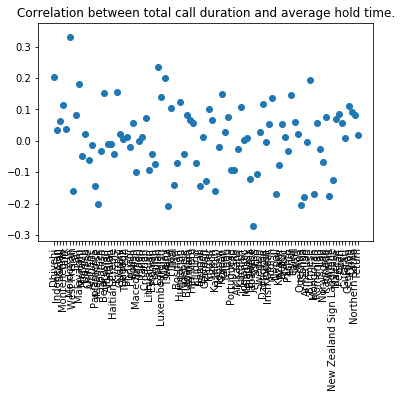

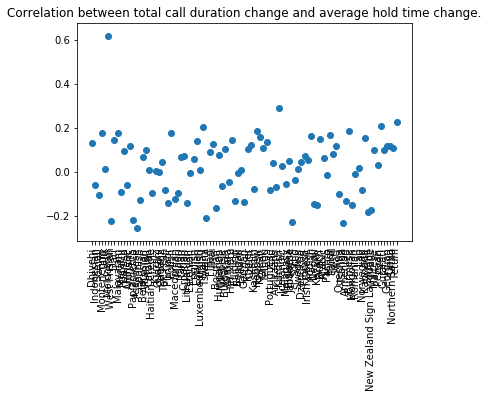

In [328]:
df_language={}
df_language_corr={}
df_language_duration_change={}
df_language_hold_change={}
df_language_change_corr={}
for i in languageSet:
    df_language[i] = df3_2[df3_2['language']==i]
    df_language_corr[i]= df_language[i].duration.astype('float64').corr(df_language[i].hold_time.astype('float64'))
    df_language_duration_change[i]=df_language[i]['duration'].astype('float64').pct_change()
    df_language_hold_change[i]=df_language[i]['hold_time'].astype('float64').pct_change()
    df_language_change_corr[i]=df_language_duration_change[i].corr(df_language_hold_change[i])
#for key in df_language_corr.keys():
#    print(key, df_language_corr[key])
#    print(key, df_language_change_corr[key])
plt.scatter(x=df_language_corr.keys(), y=df_language_corr.values())
plt.xticks(rotation='vertical')
plt.title("Correlation between total call duration and average hold time.")
plt.show()

plt.scatter(x=df_language_change_corr.keys(), y=df_language_change_corr.values())
plt.xticks(rotation='vertical')
plt.title("Correlation between total call duration change and average hold time change.")
plt.show()

In [330]:
for key in df_language_change_corr.keys():
    if df_language_change_corr[key]>0.5:
        print(key, df_language_change_corr[key])

Moldovan 0.6170535091175928


In [333]:
print(df3_2[df3_2['language']=='Moldovan'].shape)

(87, 4)


The correlation between call duration and hold time ranges between about -0.3 and 0.3, implying the two are not very correlated day by day.  With one exception, similar results are true for changes in duration and hold time.  The exception, Moldovan, has a relatively small number of calls so may be a statistical fluctuation as a correlation of 0.62 isn't very compelling, or it could be the case that there may not be many interpreters for that language.

Let's see if the days of the week matter for duration and hold time.

In [355]:
df3_1['Weekday'] = df3_1['date'].apply(lambda x: x.weekday())

In [369]:
df3_1_Monday=df3_1[df3_1['Weekday']==0]
df3_1_Tuesday=df3_1[df3_1['Weekday']==1]
df3_1_Wednesday=df3_1[df3_1['Weekday']==2]
df3_1_Thursday=df3_1[df3_1['Weekday']==3]
df3_1_Friday=df3_1[df3_1['Weekday']==4]
df3_1_Saturday=df3_1[df3_1['Weekday']==5]
df3_1_Sunday=df3_1[df3_1['Weekday']==6]

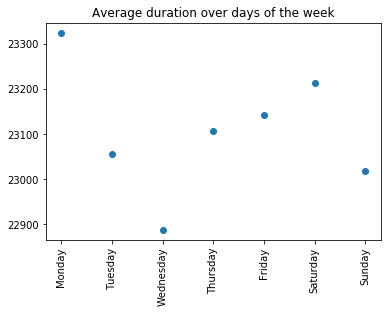

In [371]:
df3_1_WeekdayDuration={
    'Monday':df3_1_Monday['duration'].mean(),
    'Tuesday':df3_1_Tuesday['duration'].mean(),
    'Wednesday':df3_1_Wednesday['duration'].mean(),
    'Thursday':df3_1_Thursday['duration'].mean(),
    'Friday':df3_1_Friday['duration'].mean(),
    'Saturday':df3_1_Saturday['duration'].mean(),
    'Sunday':df3_1_Sunday['duration'].mean()
}

plt.scatter(x=df3_1_WeekdayDuration.keys(), y=df3_1_WeekdayDuration.values())
plt.xticks(rotation='vertical')
plt.title("Average duration over days of the week")
plt.show()

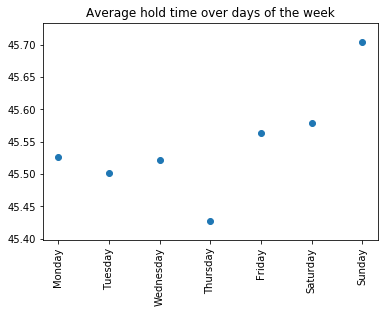

In [372]:
df3_1_WeekdayHold={
    'Monday':df3_1_Monday['hold_time'].mean(),
    'Tuesday':df3_1_Tuesday['hold_time'].mean(),
    'Wednesday':df3_1_Wednesday['hold_time'].mean(),
    'Thursday':df3_1_Thursday['hold_time'].mean(),
    'Friday':df3_1_Friday['hold_time'].mean(),
    'Saturday':df3_1_Saturday['hold_time'].mean(),
    'Sunday':df3_1_Sunday['hold_time'].mean()
}

plt.scatter(x=df3_1_WeekdayHold.keys(), y=df3_1_WeekdayHold.values())
plt.xticks(rotation='vertical')
plt.title("Average hold time over days of the week")
plt.show()

Interestingly, Wednesday has the lowest duration time and Thursday has the lowest hold time.  The weekends have about as high of duration as weekdays and Sundays have the longest hold time.

#### iii) ... creates output of the following, summing duration and averaging hold time for each language per day by hour in the data set:
#### Language | Duration | Hold Time | Date | Hour of Day

In [139]:
cur.close()
cur=conn.cursor()
cur.execute("\
SELECT language, SUM(duration) AS duration, \
SUM(interpreter_hold_time) AS hold_time, \
TO_CHAR(call_start,'YYYY-MM-DD') AS date, TO_CHAR(call_start,'hh24') AS hour_of_day \
FROM call_data \
GROUP BY language, date, TO_CHAR(call_start,'hh24')")
rows=cur.fetchall()
df3_3=pd.DataFrame(rows)
df3_3.columns=[desc[0] for desc in cur.description]
print(df3_3)

         language  duration  hold_time        date hour_of_day
0       Afrikaans  9         51         2018-01-01  01        
1       Afrikaans  94        10         2018-01-01  03        
2       Afrikaans  36        22         2018-01-01  04        
3       Afrikaans  156       54         2018-01-01  05        
4       Afrikaans  98        64         2018-01-01  07        
5       Afrikaans  143       10         2018-01-01  08        
6       Afrikaans  456       101        2018-01-01  10        
7       Afrikaans  65        81         2018-01-01  11        
8       Afrikaans  304       155        2018-01-01  12        
9       Afrikaans  143       14         2018-01-01  13        
10      Afrikaans  1         55         2018-01-01  14        
11      Afrikaans  87        113        2018-01-01  15        
12      Afrikaans  120       58         2018-01-01  16        
13      Afrikaans  54        42         2018-01-01  17        
14      Afrikaans  175       81         2018-01-01  18 

Let's look at just one example and see how Spanish interpreter duration and hold time changes over the course of a day. We've already seen above that weekends are about as busy weekdays so we won't separate those.

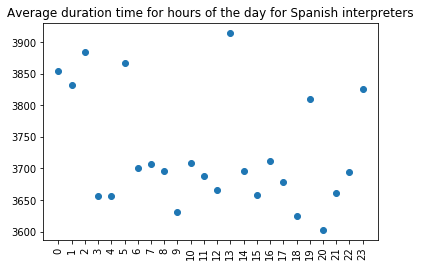

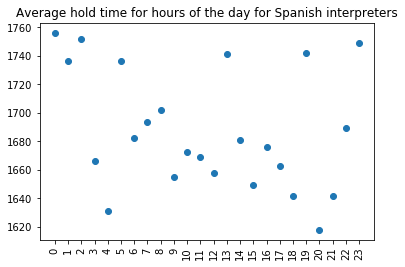

In [381]:
df3_3_hours={}
df3_3_hoursDuration={}
df3_3_hoursHold={}
df3_3_Spanish=df3_3[df3_3['language']=='Spanish']

for i in range(24):
    df3_3_hours[str(i)]=df3_3_Spanish[df3_3_Spanish['hour_of_day']=="%02d" % i]
for key in df3_3_hours.keys():
    df3_3_hoursDuration[key]=df3_3_hours[key]['duration'].mean()
    df3_3_hoursHold[key]=df3_3_hours[key]['hold_time'].mean()
plt.scatter(x=df3_3_hoursDuration.keys(), y=df3_3_hoursDuration.values())
plt.xticks(rotation='vertical')
plt.title("Average duration time for hours of the day for Spanish interpreters")
plt.show()

plt.scatter(x=df3_3_hoursHold.keys(), y=df3_3_hoursHold.values())
plt.xticks(rotation='vertical')
plt.title("Average hold time for hours of the day for Spanish interpreters")
plt.show()

The times with the longest duration are in the early morning, 1pm (after lunch) and at 7pm (after typical workday) and 11pm.  These also correlate with the longest hold times of the day, implying that the correlation calculation above didn't have the granularity to see the correlation between duration and hold time. Let's check that.

In [386]:
durationList=[]
holdList=[]
for i in range(24):
    durationList.append(df3_3_hoursDuration[str(i)])
    holdList.append(df3_3_hoursHold[str(i)])
np.corrcoef(durationList, holdList)[0, 1]


0.939278318105805

This shows a strong correlation between duration and hold time when we look at hours in the day. The visuals also show what times of day could use more interpreters.  This analysis can also be expanded to look at specific days of the week, holidays, specific companies, etc, and can be used to determine when more resources are required to cut hold times.

In [140]:
df3_1.to_csv("IanSnyderThirdDeliverableParti")
df3_2.to_csv("IanSnyderThirdDeliverablePartii")
df3_3.to_csv("IanSnyderThirdDeliverablePartiii")